# Your Community Eatery

## Welcome to your local (if you're in Phoenix) restaurant recommender! 

We are going to take a walk through the process of creating a recommender based on collaborative filtering of Yelp review data. Follow along here for the full story...

In [3]:
# Project specific modules
from src.pipeline import YourCommunityEatery
from website.src.functions import build_item_map, get_recs

# Avoid restarting Kernal each time we update modules
%load_ext autoreload
%autoreload 2

# The basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Spark library and functions
import pyspark as ps
import pyspark.sql.types as types
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import to_timestamp

# Sklearn Modeling
# from sklearn.model_selection import train_test_split


# Surprise modeling
from surprise import SVD
import surprise
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split

# Persistance
import pickle

# Housekeeping
from io import StringIO
from datetime import datetime

# Initial EDA

This dataset is actually too big to simply load into a Pandas dataframe (at least on my machine - 8 GB memory). Although I know people with 16 GB machines have loaded it successfully, so far I get memory errors when trying to load it onto a 16 GB AWS EC2 instance (and I'm still searching for an answer/solution on that). Regardless, we can do some initial EDA to just see what we have by using Spark!

In [35]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )

review_df = spark.read.json("data/review.json")
# checkin_df = spark.read.json("data/checkin.json")
# tip_df = spark.read.json("data/tip.json")
# user_df = spark.read.json("data/user.json")
business_df = spark.read.json("data/business.json")

We plan to work with the review and business datasets. So let's see how many distinct values for all fields we have on those.

Number of states covered in the data: 36
Number of cities covered in the data: 1204


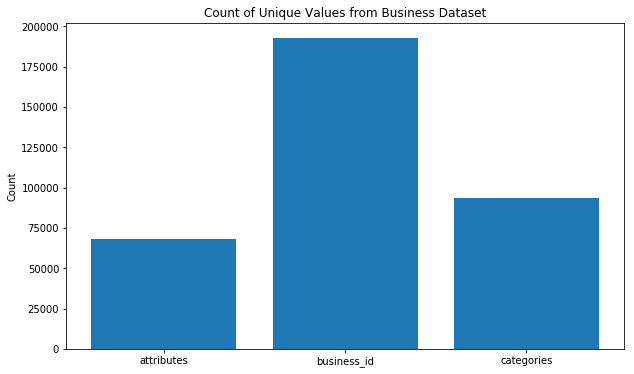

In [61]:
this = business_df.agg(*(countDistinct(col(c)).alias(c) for c in business_df.columns))
this = this.take(1)[0].asDict()

print('Number of states covered in the data: {}'.format(this['state']))
print('Number of cities covered in the data: {}'.format(this['city']))

drop_list = ['city', 'state', 'address', 'hours', 'is_open', 
             'latitude', 'longitude', 'name', 'postal_code', 
             'review_count', 'stars']
for _ in drop_list:
    this.pop(_)

fig, ax = plt.subplots(figsize = (10, 6))
ax.bar(range(len(this)), list(this.values()), align='center')
ax.set_title('Count of Unique Values from Business Dataset')
ax.set_ylabel('Count')
_ = plt.xticks(range(len(this)), list(this.keys()))

Number of businesses covered in the review data: 192606


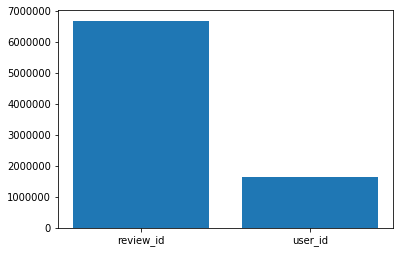

In [68]:
this = review_df.agg(*(countDistinct(col(c)).alias(c) for c in review_df.columns))
this = this.take(1)[0].asDict()

print('Number of businesses covered in the review data: {}'.format(this['business_id']))

drop_list = ['cool', 'funny', 'useful', 'text', 'stars', 'date', 'business_id']
for _ in drop_list:
    this.pop(_)

plt.bar(range(len(this)), list(this.values()), align='center')
_ = plt.xticks(range(len(this)), list(this.keys()))

## We would like to develop a restaurant recommender for one metropolitan area

Given that we are developing a similarity/collaborative-filtering based recommender, we are going to limit this project to one geographic area since there wouldn't be much if any signal on one geo for another. Also, given the demands of this dataset, it will be much more manageable to filter it down to one city so we can simply work with Pandas. But which region to pick?

Let's look at some density metrics to decide...

In [63]:
def calculate_region_density(state, businesses, bus_reviews):
    num_businesses = businesses.filter((businesses.categories.like('%Restaurants%')) &
                                (business_df.state == state)).count()
    num_reviews = bus_reviews.filter((bus_reviews.categories.like('%Restaurants%')) &
                                (bus_reviews.state == state)).count()
    return num_reviews/num_businesses

def compare_region_densities(regions, businesses, bus_reviews):
    max_density = 0
    density_dict = {}
    for region in regions:
        density = calculate_region_density(region, businesses, bus_reviews)
        density_dict[region] = density
        if density > max_density:
            max_density = density
            max_region = region

    print('Best Region: {}\nBest Density: {}'.format(max_region, max_density))
    return density_dict

In [66]:
# Join business and review df's so that we can really look at this
bus_review_df = review_df.join(business_df, 
                               review_df.business_id == business_df.business_id,
                                how='left')

Best Region: NV
Best Density: 178.80932802261339


Text(0.5, 1.0, 'Review Density by Region')

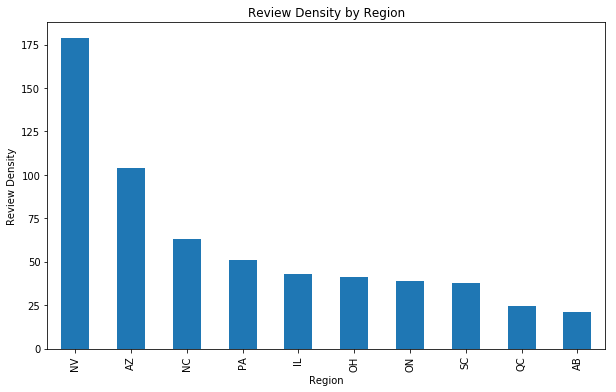

In [67]:
regions = ['AZ', 'ON', 'NC', 'AB', 'NV', 'OH', 'PA', 'IL', 'SC', 'QC']

density_dict = compare_region_densities(regions, business_df, bus_review_df)

pd.DataFrame.from_dict(density_dict, orient = 'index').sort_values(0, ascending = False).plot.bar(legend = False, figsize = (10, 6))
plt.ylabel('Review Density')
plt.xlabel('Region')
plt.title('Review Density by Region')

## The winner: Arizona

We are proceeding with Arizona based businesses for this case study. Although Nevada has a greater density of reviews/restaurant, this data scientist considers it to be an anomaly in the restaurant space as well as user space given the impact tourism would have on restaurant visits/reviews. Arizona has the next highest density, would be expected to include a healthy mix of resident and non-resident reviews, most reviews are concentrated around Phoenix, and we would expect Phoenix to have a diverse group of users. Note that it was specified by Yelp that their dataset focuses on 8 metropolitan areas, and we have validated (though not shown here) that the Arizona locations are in/around Phoenix.

Now that we have a region in mind, we will be able to fit the subject piece of the dataset into memory in Pandas.

But don't forget to close Spark!

In [70]:
spark.stop()

# Loading Data into Pandas - Pipeline Demo

Now that we have a few criteria on which to select a limited volume of the data (Restaurants and Arizona), our subject dataset will be much more manageable and will easily fit in memory. We've developed a pipeline just for handling this!

In [4]:
# Instantiate object specifying that we don't have the memory to handle the full dataset
pipe = YourCommunityEatery(save_memory=True)

In [40]:
# Read data in from files 
# There is quite a bit of data to load and it has to be filtered 
# based on some conditions to fit in memory, so this takes a while
pipe.read_data(data_dir_path='data/')

Reading business data...
Reading review data...


In [12]:
# Alternatively, we saved the results from above so that
# you can just load it from a file!
# This isn't super fast, but much better than the above.
pipe.bus_review_df = pd.read_json('data/bus_review_df.json', orient = 'records')

# Now that we have our data, let's delve into some additional EDA
#### At this point our data is saved in 'bus_review_df' which is an attribute of our pipe object

What time frame do these reviews span?

In [161]:
begin = pipe.bus_review_df.date.min()
end = pipe.bus_review_df.date.max()
print('These ratings range from {} to {}.'.format(begin.year, end.year))

These ratings range from 2005 to 2018.


Long span of data, nice! And what kind of distribution of reviews over time might we see for that duration?

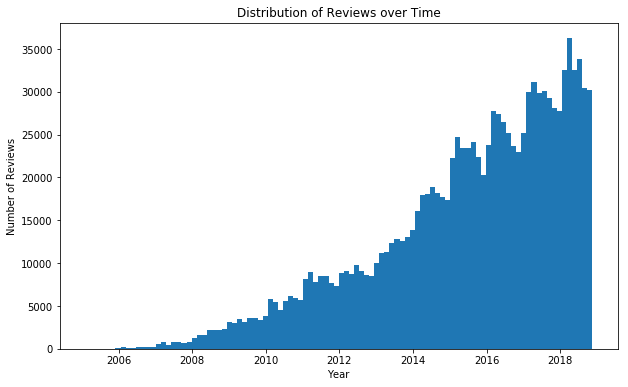

In [162]:
ax = pipe.bus_review_df.date.hist(bins = 100, figsize = (10, 6))
ax.grid(False)
ax.set_title('Distribution of Reviews over Time')
ax.set_xlabel('Year')
_ = ax.set_ylabel('Number of Reviews')

Look at that growth! Good for you, Yelp. Interesting trends after 2015, seasonality for reviews? Interesting...but out of our scope.

What is the distribution of number of users to have reviewed each restaurant? 


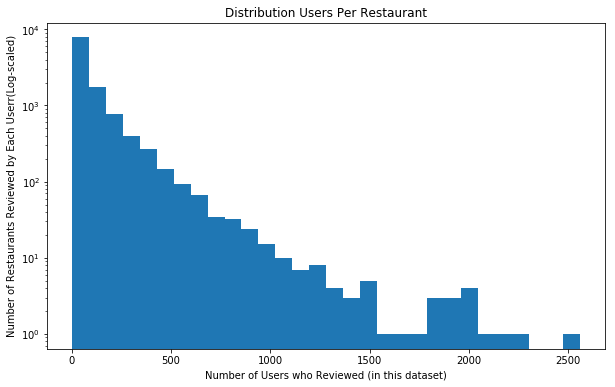

In [163]:
groups = pipe.bus_review_df.groupby('business_id')
ax = groups.user_id.nunique().hist(bins = 30, figsize = (10, 6))
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Number of Users who Reviewed (in this dataset)')
ax.set_title('Distribution Users Per Restaurant')
_ = ax.set_ylabel('Number of Restaurants Reviewed by Each Userr(Log-scaled)')

Keeping in mind this is log-scaled on the y axis, this data appears to be exponentially distributed.


What is the distribution of reviews per user?


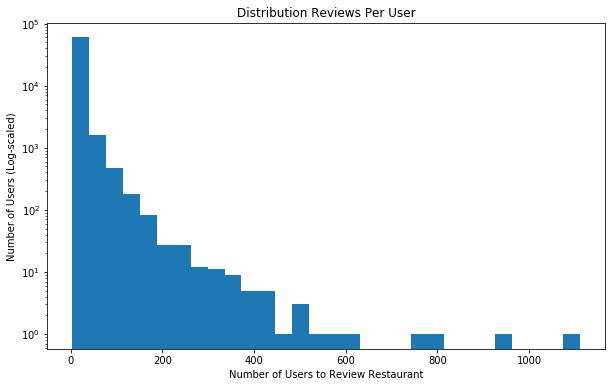

In [81]:
groups = pipe.bus_review_df.groupby('user_id')
ax = groups.review_id.nunique().hist(bins = 30, figsize = (10, 6))
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Number of Users to Review Restaurant')
ax.set_title('Distribution Reviews Per User')
_ = ax.set_ylabel('Number of Users (Log-scaled)')

From the graph above, we are able to see that this is exponentially distributed. There are several users who have made significant numbers of reviews. Normally this might be cause for concern that their reviews are not legitimate; however, this dataset consists only of reviews that Yelp has validated and "recommended", so they are likely just very passionate about food. But skeptical scientists that we are, we'll not just take their word for it...ok, I admit that I'm mostly just curious to see what kind of stuff a person who writes over 1,200 reviews has to say.

Let's verify the text of the highest volume user to be sure they are not a bot. As shown below, only one user exceeded 1000 reviews and their id is 'ELcQDlf69kb-ihJfxZyL0A'. Feel free to adjust the index on the .iloc to see a few different reivews (just put in a number between 0 and 1277).

In [211]:
pipe.bus_review_df[pipe.bus_review_df.user_id == 'ELcQDlf69kb-ihJfxZyL0A'].text.iloc[356]

'If you dine-in, you will likely be annoyed by some screaming kid and their mommy, but if you can ignore that noise for about ten minutes, you will be rewarded with a delicious waffle experience. I simply had the churro waffle and got my free YELP topping of bananas. The cinnamon sugar waffle was loaded with cinnamon cream and fruit. It was a chewy waffle and stayed hot the entire visit. You will need both knife and fork, but every bite was very tasty and unique as well. All totaled, it was just over 5 bucks, so a good value and fairly filling breakfast.'

...ok, review for index 356 is pretty shameful. But clearly, this is not a bot...just definitely someone who has a lot of time on their hands. Outlier though they may be, their reviews appear to be genuine, so we will graciously accept their contributions to our density.

## In  planning for a collaborative-filtering based recommender, we need to take a look at our density of reviews

In [13]:
density_pre = pipe.calculate_density()
print('The density of our data is {:.6f}'.format(density_pre))

The density of our data is 0.000320


Ouch, that is extremely low. Let's take a look at how we might improve that.

## For model training, let's consider trimming down our dataset to increase density

Normally, taking samples of your data to increase density is a non-starter, but we may have some clever ways of taking samples based on what we've learned so far. Let's start with getting later time periods, since we have far more reviews in the later segment of the data. We will use the "filter_by_review_date" method to modify our dataframe in place to only include reviews during-or-after a specified year.

In [14]:
pipe.filter_by_review_date(threshold = 2013)

In [15]:
density_time = pipe.calculate_density()
print('The density of our data is {:.6f}'.format(density_time))

The density of our data is 0.000320


As it turns out, the density is not significantly affected by taking slices for more recent data. We did this for all year thresholds from 2005 through 2017 and found that we were only able to achieve a change of about 10% from the above figure, and it was for the worse. It is not being shown here because the dataframe gets modified in place, and we'd like to spare you from having to reload it to get back to normal. Let's proceed with a threshold of 2013 for the sake of having some value for recency without sacrificing too much data.

It is expected that the restaurants and users with low counts of reviews are making our user-restaurant matrix too sparse. Let's cut off those density killers and re-evaluate some of these metrics.

In [16]:
thresholds = [2, 3, 4, 5, 6]
amount_of_data = []
for thresh in thresholds:
    groups = pipe.bus_review_df.groupby('user_id')
    user_selection = groups.review_id.nunique()>=thresh
    user_selection = user_selection[user_selection]
    trimmed_df = pipe.bus_review_df[pipe.bus_review_df.user_id.isin(user_selection.index)]

    full = len(pipe.bus_review_df)
    trimmed = len(trimmed_df)
    amount_of_data.append(trimmed/full)
    print('Removing users with less than {} reviews leaves us with {:.2f}% of the original amount of reviews.'.format(thresh, 100*(trimmed)/full))

Removing users with less than 2 reviews leaves us with 83.37% of the original amount of reviews.
Removing users with less than 3 reviews leaves us with 73.01% of the original amount of reviews.
Removing users with less than 4 reviews leaves us with 65.44% of the original amount of reviews.
Removing users with less than 5 reviews leaves us with 59.54% of the original amount of reviews.
Removing users with less than 6 reviews leaves us with 54.73% of the original amount of reviews.


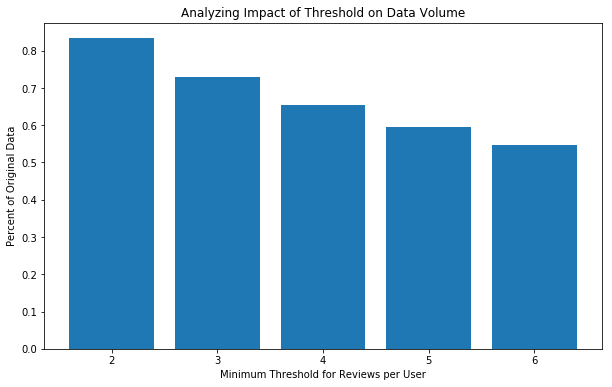

In [17]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.bar(thresholds, amount_of_data)
ax.set_title('Analyzing Impact of Threshold on Data Volume')
ax.set_ylabel('Percent of Original Data')
_ = ax.set_xlabel('Minimum Threshold for Reviews per User')

In [18]:
thresholds = [20, 30, 40, 50]
amount_of_data = []
for thresh in thresholds:
    groups = pipe.bus_review_df.groupby('business_id')
    business_selection = groups.user_id.nunique()>=thresh
    business_selection = business_selection[business_selection]
    trimmed_df = pipe.bus_review_df[pipe.bus_review_df.business_id.isin(business_selection.index)]

    full = len(pipe.bus_review_df)
    trimmed = len(trimmed_df)
    amount_of_data.append(trimmed/full)
    print('Removing businesses reviewed by less than {} users leaves us with {:.2f}% of the original amount of reviews.'.format(thresh, 100*(trimmed)/full))

Removing businesses reviewed by less than 20 users leaves us with 96.91% of the original amount of reviews.
Removing businesses reviewed by less than 30 users leaves us with 94.44% of the original amount of reviews.
Removing businesses reviewed by less than 40 users leaves us with 91.96% of the original amount of reviews.
Removing businesses reviewed by less than 50 users leaves us with 89.42% of the original amount of reviews.


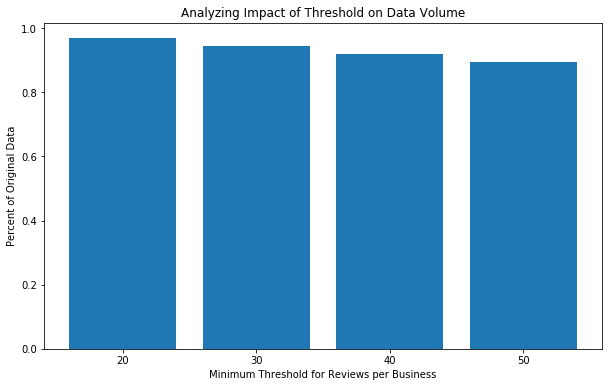

In [20]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.bar([1, 2, 3, 4], amount_of_data, tick_label = thresholds)
ax.set_title('Analyzing Impact of Threshold on Data Volume')
ax.set_ylabel('Percent of Original Data')
_ = ax.set_xlabel('Minimum Threshold for Reviews per Business')

### Based on these results, we are selecting based on the following:
* Clip users with less than 4 reviews
* Clip businesses with less than 40 reviews
* Clip users with less than 4 reviews again.

We can ue the built-in methods to accomplish this! But note that these operations are performed in series, and each one will affect ther other. That is, if we first filter out users with less than 4 reviews and then filter out restaurants with less than 40 reviews, we end up eliminating some restaurants that were counting as the 4th review for some of those users. 

Given the low values for user thresholds, we would prefer to ensure that we apply that threshold last (this helps improve end density). After some trial and error, arrived at the process spelled out in the bullets above as giving us good density without clipping too much data. 

In [21]:
pipe.filter_low_density_users(threshold=4)
density_user1 = pipe.calculate_density()
pipe.filter_low_density_items(threshold=40)
density_item = pipe.calculate_density()
pipe.filter_low_density_users(threshold=4)
density_final = pipe.calculate_density()

And now let's check the resulting distribution of reviews/business to make sure there won't be too many density-killing businesses left in the data.

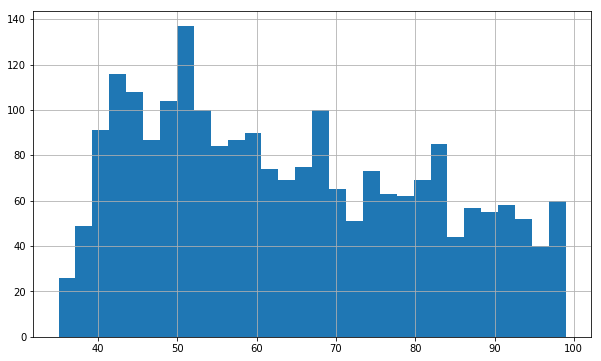

In [22]:
mask = pipe.bus_review_df.groupby('business_id').count().user_id < 100
_ = pipe.bus_review_df.groupby('business_id').count().user_id[mask].hist(bins = 30, figsize=(10, 6))

And let's plot the progression of density...

Final Density is 0.00257


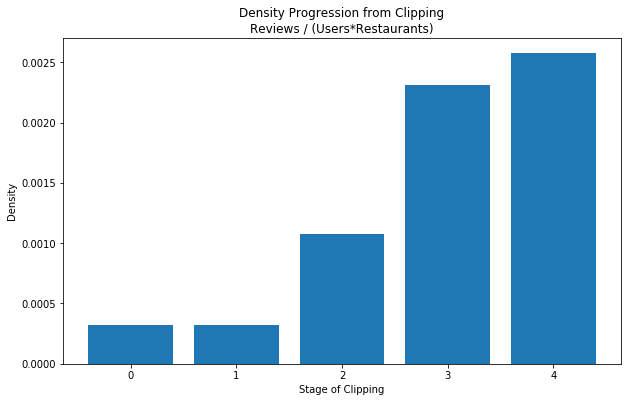

In [23]:
densities = [density_pre, density_time, density_user1, density_item, density_final]
fig, ax = plt.subplots(figsize = (10, 6))
ax.bar(list(range(len(densities))), densities)
ax.set_ylabel('Density')
ax.set_title('Density Progression from Clipping\nReviews / (Users*Restaurants)')
ax.set_xlabel('Stage of Clipping')
print('Final Density is {:.5f}'.format(density_final))

In [9]:
pipe.factorize()

In [10]:
# Save only the necessities to json
pipe.bus_review_df.drop(columns = ['cool', 'funny', 'text', 'user_id', 
                                   'latitude', 'longitude', 'date', 
                                   'categories', 'useful', 'avg_stars', 
                                   'address', 'city'], inplace = True)

In [11]:
pipe.persist_subject_data('website/data/processed_df')
pipe.persist_subject_data('data/processed_df')

# Time to Model

In [177]:
# For picking up a restarted notebook, you can load up a previously prepared df here
pipe.bus_review_df = pd.read_json('data/processed_df.json', orient = 'records')

In [180]:
df = pipe.bus_review_df[['uid', 'iid', 'review_stars']]

In [181]:
# And wipe the pipe to save memory
pipe.bus_review_df = None
pipe.review_df = None
pipe.business_df = None

In [182]:
# A reader is needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df, reader)
trainset, testset = train_test_split(data, test_size = .05, random_state = 2)

In [ ]:
algs = [
        SVD(), 
        surprise.SlopeOne(), 
        surprise.NMF(),
        surprise.NormalPredictor(), 
        surprise.KNNBaseline(),
        surprise.KNNBasic(), 
        surprise.KNNWithMeans(),
        surprise.KNNWithZScore(), 
        surprise.BaselineOnly(),
        surprise.CoClustering()
        ]

# Iterate over all algorithms
for alg in algs:
    
    # Take a look at cross validation results to compare model types
    print(cross_validate(alg, data, measures=['RMSE'], cv=5, verbose=True))


Estimating biases using als...


NormalPredictor

* Mean RMSE on 5 splits: 1.827

In [24]:
naive_score = 1.827

In [159]:
KNN_model = pickle.load(open('models/top_grid_KNNBaseline_model.pkl', 'rb'))

In [161]:
KNN_params = pickle.load(open('model_results/top_grid_KNNBaseline_params.pkl', 'rb'))
KNN_params

{'k': 100,
 'min_k': 4,
 'bsl_options': {'method': 'als', 'reg': 1},
 'sim_options': {'name': 'cosine',
  'min_support': 1,
  'user_based': False,
  'shrinkage': 50},
 'random_state': 2}

In [25]:
KNN_score = pickle.load(open('model_results/top_grid_KNNBaseline_score.pkl', 'rb'))
KNN_score

1.1728866595837093

In [26]:
SVD_score = pickle.load(open('model_results/top_grid_SVD_score2.pkl', 'rb'))
SVD_score

1.1570598159339343

# Now we've determined a model that we prefer, let's get the similarity matrix from it

In [163]:
alg = surprise.KNNBaseline(KNN_params)

alg.fit(trainset)

NameError: name 'trainset' is not defined

In [ ]:
similarity_matrix = alg.compute_similarities()

In [ ]:
version = input('Please provide a distinguishing feature for this version:\n')
with open('data/similarity_matrix{}.pkl'.format(version), 'wb') as file:
    pickle.dump(similarity_matrix, file)

Text(0.5, 1.0, 'Model Performance Evaluation')

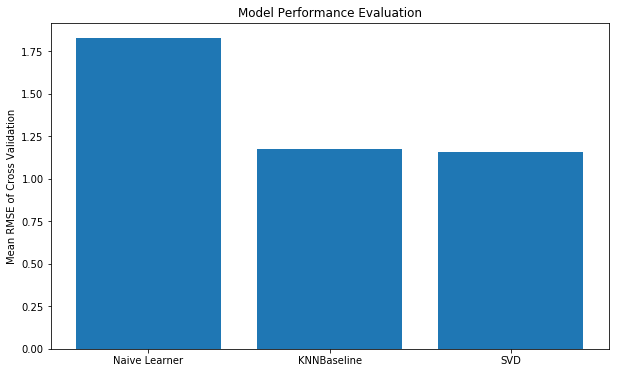

In [27]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.bar(['Naive Learner', 'KNNBaseline', 'SVD'], [naive_score, KNN_score, SVD_score])
ax.set_ylabel('Mean RMSE of Cross Validation')
ax.set_title('Model Performance Evaluation')

In [ ]:
# y = df['review_stars']
# X = df.drop('review_stars', axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# identifier_df_train = X_train[['user_id', 'business_id']]
# identifier_df_test = X_test[['user_id', 'business_id']]

#     # fit the model
#     alg_name = str(algorithm)[str(algorithm).find('ization')+8 : str(algorithm).find('obj')-1]
#     print('Fitting algorithm {}'.format(alg_name))
#     algorithm.fit(train_set)

#     # run predictions over
#     print('Predicting algorithm {}'.format(alg_name))
#     model_predictions = []
#     model_ratings = []
#     for idx, row in X_test.iterrows():
#         prediction = algorithm.predict(row[0], row[1])
#         model_predictions.append(prediction)
#         model_ratings.append(prediction[3])

#     # Pickle the models
#     pred_pkl_file = alg_name + '_predictions.pkl'
#     ratings_pkl_file = alg_name + '_ratings.pkl'
#     pickle.dump(model_predictions, open(pred_pkl_file, 'wb'))
#     pickle.dump(model_ratings, open(ratings_pkl_file, 'wb'))


# Make Recommendations

In [ ]:
# Load similarities, bus_review_df, and item map to use for recommending
with open('website/models/item_map.pkl', 'rb') as file:
    item_map = pickle.load(file)

with open('website/models/KNNBaseline_similarities.pkl', 'rb') as file:
    similarities = pickle.load(file)

df = pd.read_json('data/processed_df.json', orient='records')
    
selection = ['In-N-Out Burger', "Chick-fil-A", 'The Stand', 'ATL Wings']
selection = ['The Stand', 'The Stand', 'The Stand', 'The Stand']
selection = ["Hungry Howie's Pizza", "In-N-Out Burger", "Chick-fil-A", "Chick-fil-A"]

In [ ]:
recommendations = get_recs(similarities, df, item_map, 3, selection)
recommendations

In [113]:
pipe.bus_review_df[pipe.bus_review_df.name == 'Beaver Choice']

,business_id,is_open,name,review_id,review_stars,state,iid,uid
123818,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,g1jg_DKzxZlCFjph14c5hg,5,AZ,709,7303
123820,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,X6sGqmNX2COiSbeL6jUP5Q,1,AZ,709,27863
123821,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,TaMsbo-MkCy7upr66cpvPg,5,AZ,709,20729
123822,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,FgD549Q2jrmG8cwty31aEw,5,AZ,709,27864
123825,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,xSf8g6JSvHwPNzAV-3TspA,5,AZ,709,27865
123826,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,HspPm_JC--aKoF4kCEZmAA,5,AZ,709,20984
123827,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,RTXpbliOwZny7gwdcURqvg,5,AZ,709,2041
123828,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,gNNpZV5kng-uhN4hZagKXQ,2,AZ,709,1523
123829,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,f4geLGpPyBPdOmKRnPgwlw,5,AZ,709,14744
123830,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,wFEhhGhbTRD2Pav0ImF9Lg,4,AZ,709,2172
